# Base Price Only: Price Dispersion vs Number of Sellers

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/tf/_kv68nm968v2txzm7v25n9kc0000gn/T/ipykernel_40126/3614414866.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


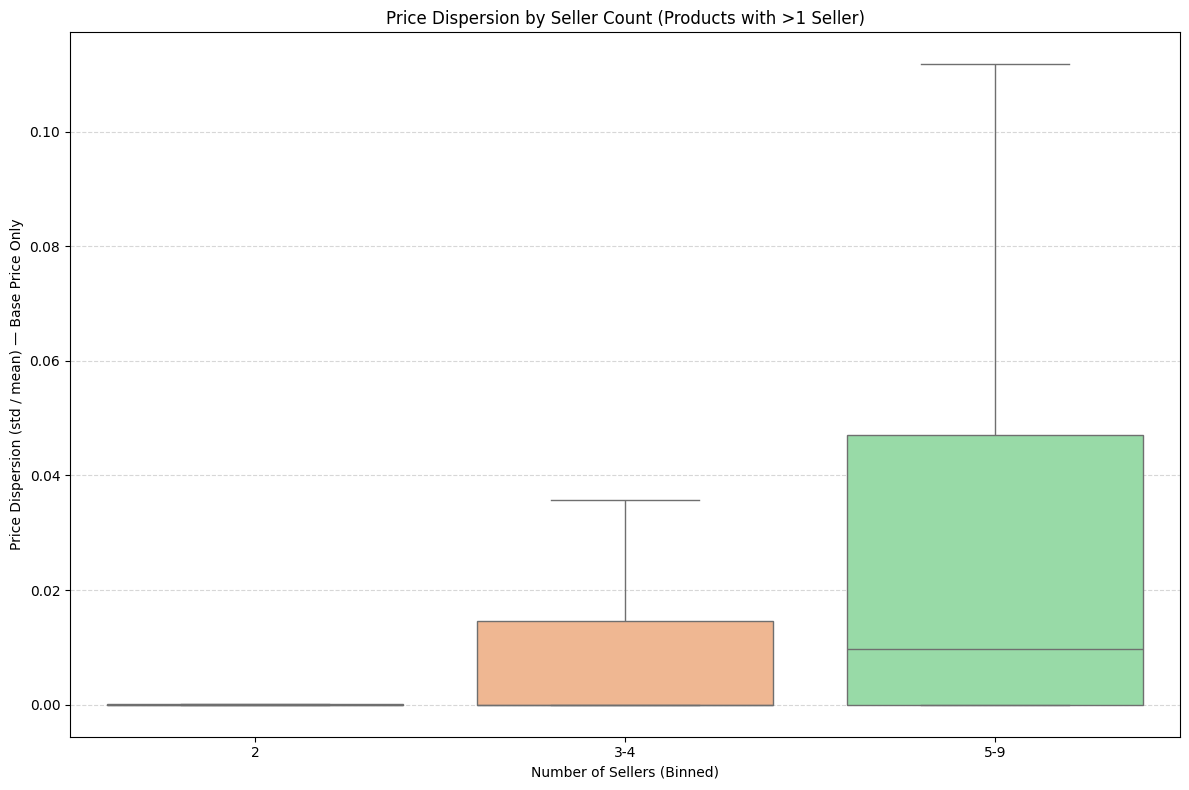

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load datasets ---
orders = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_orders_dataset.csv')
order_items = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_order_items_dataset.csv')

# --- Step 1: Extract month from order date ---
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# --- Step 2: Merge orders with order_items ---
merged = order_items.merge(orders[['order_id', 'month']], on='order_id')

# --- Step 3: Calculate price-only dispersion per product per month ---
dispersion = (
    merged.groupby(['product_id', 'month'])['price']
    .agg(['mean', 'std']).reset_index()
)
dispersion['dispersion'] = dispersion['std'] / dispersion['mean']

# --- Step 4: Count unique sellers per product ---
seller_counts = order_items.groupby('product_id')['seller_id'].nunique().reset_index(name='num_sellers')

# --- Step 5: Merge dispersion with seller count ---
dispersion_with_sellers = dispersion.merge(seller_counts, on='product_id', how='left')

# --- Remove products with only 1 seller ---
dispersion_with_sellers = dispersion_with_sellers[dispersion_with_sellers['num_sellers'] > 1]

# --- Step 6: Bin seller counts ---
dispersion_with_sellers['seller_bin'] = pd.cut(
    dispersion_with_sellers['num_sellers'],
    bins=[1, 2, 4, 9],
    labels=['2', '3-4', '5-9'],
    right=True
)

# --- Step 7: Plot boxplot ---
plt.figure(figsize=(12,8))
sns.boxplot(
    data=dispersion_with_sellers,
    x='seller_bin',
    y='dispersion',
    palette='pastel',
    showfliers=False
)

plt.xlabel('Number of Sellers (Binned)')
plt.ylabel('Price Dispersion (std / mean) — Base Price Only')
plt.title('Price Dispersion by Seller Count (Products with >1 Seller)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Base Price Only: Regression Results

In [2]:
import pandas as pd
from linearmodels.panel import PanelOLS

# --- Load data ---
orders = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_orders_dataset.csv')
order_items = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_order_items_dataset.csv')
products = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_products_dataset.csv')

# --- Prepare monthly variable ---
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['month'] = orders['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

# --- Merge orders with order_items ---
order_items = order_items.merge(orders[['order_id', 'month']], on='order_id')

# --- Compute dispersion (std / mean of base price per product-month) ---
dispersion = (
    order_items.groupby(['product_id', 'month'])['price']
    .agg(['mean', 'std']).reset_index()
)
dispersion['dispersion'] = dispersion['std'] / dispersion['mean']

# --- Add product category ---
dispersion = dispersion.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

# --- Add number of sellers per product ---
seller_counts = order_items.groupby('product_id')['seller_id'].nunique().reset_index(name='num_sellers')
dispersion = dispersion.merge(seller_counts, on='product_id', how='left')

# --- Clean data ---
df = dispersion.dropna(subset=['dispersion', 'num_sellers', 'product_category_name']).copy()
df = df[df['num_sellers'] > 1]

# --- Drop singleton (category, month) combos ---
counts = df.groupby(['product_category_name', 'month']).size().reset_index(name='n')
df = df.merge(counts, on=['product_category_name', 'month'])
df = df[df['n'] > 1].drop(columns='n')

# --- Set multi-index for panel ---
df = df.set_index(['product_category_name', 'month'])

# --- Run panel regression with entity (category) and time (month) fixed effects ---
model = PanelOLS.from_formula(
    formula='dispersion ~ num_sellers + EntityEffects + TimeEffects',
    data=df
)

# --- Fit the model ---
results = model.fit(cov_type='clustered', cluster_entity=True)

# --- Show results ---
print(results.summary)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                          PanelOLS Estimation Summary                           
Dep. Variable:             dispersion   R-squared:                        0.0075
Estimator:                   PanelOLS   R-squared (Between):              0.5452
No. Obs

# Base + Shipping: Price Dispersion vs Number of Sellers

/var/folders/tf/_kv68nm968v2txzm7v25n9kc0000gn/T/ipykernel_40126/2191221880.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


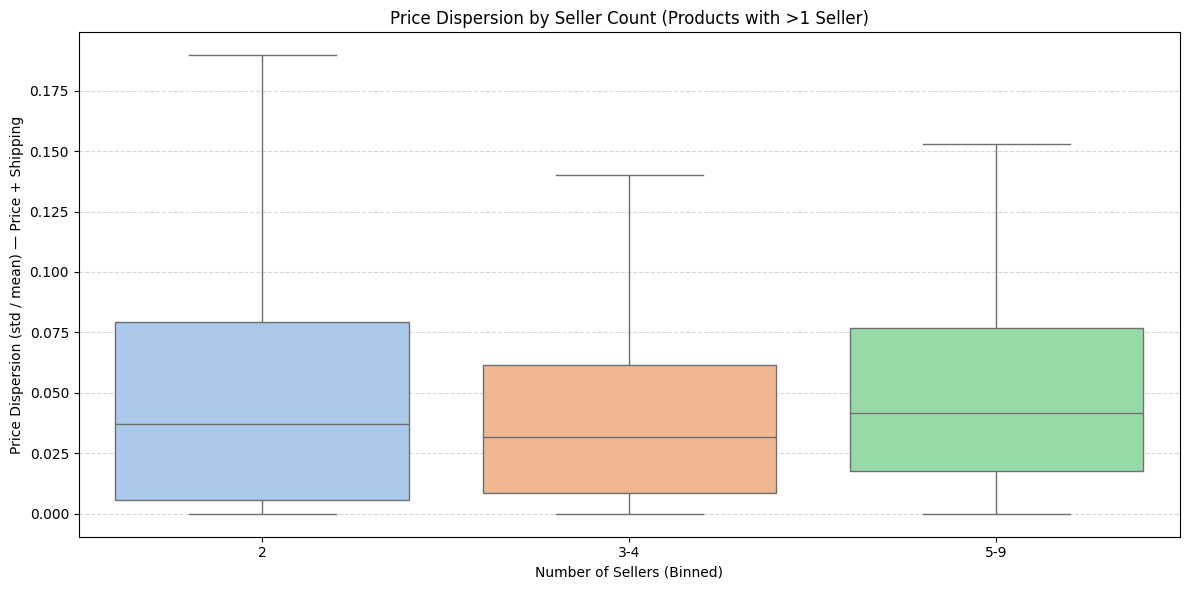

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load datasets ---
orders = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_orders_dataset.csv')
order_items = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_order_items_dataset.csv')

# --- Step 1: Compute price + shipping ---
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['month'] = orders['order_purchase_timestamp'].dt.to_period('M')

order_items['total_price'] = order_items['price'] + order_items['freight_value']

merged = order_items.merge(orders[['order_id', 'month']], on='order_id')

# --- Step 2: Calculate price dispersion per product per month ---
dispersion = (
    merged.groupby(['product_id', 'month'])['total_price']
    .agg(['mean', 'std']).reset_index()
)
dispersion['dispersion'] = dispersion['std'] / dispersion['mean']

# --- Step 3: Count number of unique sellers per product ---
seller_counts = order_items.groupby('product_id')['seller_id'].nunique().reset_index(name='num_sellers')

# --- Step 4: Merge seller counts with dispersion data ---
dispersion_with_sellers = dispersion.merge(seller_counts, on='product_id', how='left')

# --- Remove products with only 1 seller ---
dispersion_with_sellers = dispersion_with_sellers[dispersion_with_sellers['num_sellers'] > 1]

# --- Step 5: Bin seller counts ---
dispersion_with_sellers['seller_bin'] = pd.cut(
    dispersion_with_sellers['num_sellers'],
    bins=[1, 2, 4, 9],
    labels=['2', '3-4', '5-9'],
    right=True
)

# --- Step 6: Plot boxplot ---
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=dispersion_with_sellers,
    x='seller_bin',
    y='dispersion',
    palette='pastel',
    showfliers=False
)

plt.xlabel('Number of Sellers (Binned)')
plt.ylabel('Price Dispersion (std / mean) — Price + Shipping')
plt.title('Price Dispersion by Seller Count (Products with >1 Seller)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
from linearmodels.panel import PanelOLS

# --- Load data ---
orders = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_orders_dataset.csv')
order_items = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_order_items_dataset.csv')
products = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_products_dataset.csv')

# --- Prepare monthly variable ---
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['month'] = orders['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

# --- Merge orders with order_items ---
order_items = order_items.merge(orders[['order_id', 'month']], on='order_id')

# --- Add total price column (base + shipping) ---
order_items['total_price'] = order_items['price'] + order_items['freight_value']

# --- Compute dispersion (std / mean of total price per product-month) ---
dispersion = (
    order_items.groupby(['product_id', 'month'])['total_price']
    .agg(['mean', 'std']).reset_index()
)
dispersion['dispersion'] = dispersion['std'] / dispersion['mean']

# --- Add product category ---
dispersion = dispersion.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

# --- Add number of sellers per product ---
seller_counts = order_items.groupby('product_id')['seller_id'].nunique().reset_index(name='num_sellers')
dispersion = dispersion.merge(seller_counts, on='product_id', how='left')

# --- Clean data ---
df = dispersion.dropna(subset=['dispersion', 'num_sellers', 'product_category_name']).copy()
df = df[df['num_sellers'] > 1]

# --- Drop singleton (category, month) combos ---
counts = df.groupby(['product_category_name', 'month']).size().reset_index(name='n')
df = df.merge(counts, on=['product_category_name', 'month'])
df = df[df['n'] > 1].drop(columns='n')

# --- Set multi-index for panel ---
df = df.set_index(['product_category_name', 'month'])

# --- Run panel regression with entity (category) and time (month) fixed effects ---
model = PanelOLS.from_formula(
    formula='dispersion ~ num_sellers + EntityEffects + TimeEffects',
    data=df
)

# --- Fit the model ---
results = model.fit(cov_type='clustered', cluster_entity=True)

# --- Show results ---
print(results.summary)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                          PanelOLS Estimation Summary                           
Dep. Variable:             dispersion   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):              0.0876
No. Obs

# Summary Statistics Before Regression Results in Paper

In [11]:
import pandas as pd

# Load datasets
orders = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_orders_dataset.csv')
order_items = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_order_items_dataset.csv')

# Extract month
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# Merge orders with order_items
merged = order_items.merge(orders[['order_id', 'month']], on='order_id')

# Calculate price dispersion per product-month
dispersion = (
    merged.groupby(['product_id', 'month'])['price']
    .agg(['mean', 'std']).reset_index()
)
dispersion['dispersion'] = dispersion['std'] / dispersion['mean']

# Count sellers per product-month
seller_counts = merged.groupby(['product_id', 'month'])['seller_id'].nunique().reset_index(name='num_sellers')

# Merge and filter out product-months with only one seller
dispersion_with_sellers = dispersion.merge(seller_counts, on=['product_id', 'month'], how='left')
filtered = dispersion_with_sellers[dispersion_with_sellers['num_sellers'] > 1]

# Summary statistics
avg_sellers = filtered['num_sellers'].mean()
avg_dispersion = filtered['dispersion'].mean()
share_nonzero_shipping = (order_items['freight_value'] > 0).mean()
# First general statistics
print(f"Avg sellers per product-month: {avg_sellers:.2f}")
print(f"Share of orders with non-zero shipping: {share_nonzero_shipping:.2%}")


Avg sellers per product-month: 2.11
Share of orders with non-zero shipping: 99.66%


# Post Analysis Summary Statistics

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load datasets ---
orders = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_orders_dataset.csv')
order_items = pd.read_csv('/Users/kaileysimonss/Downloads/archive/olist_order_items_dataset.csv')

# --- Prepare order data with month ---
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# --- Add total price (price + freight) ---
order_items['total_price'] = order_items['price'] + order_items['freight_value']

# --- Merge orders with order_items ---
merged_base = order_items.merge(orders[['order_id', 'month']], on='order_id')
merged_total = merged_base.copy()  # use same join for total price pipeline

# --- Base Price Dispersion ---
dispersion_base = (
    merged_base.groupby(['product_id', 'month'])['price']
    .agg(['mean', 'std']).reset_index()
)
dispersion_base['dispersion'] = dispersion_base['std'] / dispersion_base['mean']

# --- Total Price Dispersion ---
dispersion_total = (
    merged_total.groupby(['product_id', 'month'])['total_price']
    .agg(['mean', 'std']).reset_index()
)
dispersion_total['dispersion'] = dispersion_total['std'] / dispersion_total['mean']

# --- Seller count per product ---
seller_counts = order_items.groupby('product_id')['seller_id'].nunique().reset_index(name='num_sellers')

# --- Merge seller counts and filter to multi-seller products ---
def prepare_dispersion_with_sellers(df_dispersion):
    df = df_dispersion.merge(seller_counts, on='product_id', how='left')
    df = df[df['num_sellers'] > 1].copy()
    df['seller_bin'] = pd.cut(
        df['num_sellers'],
        bins=[1, 2, 4, 9, 19, float('inf')],
        labels=['2', '3-4', '5-9', '10-19', '20+'],
        right=True
    )
    return df

dispersion_base_sellers = prepare_dispersion_with_sellers(dispersion_base)
dispersion_total_sellers = prepare_dispersion_with_sellers(dispersion_total)

# --- Group and summarize (excluding count) ---
summary_base = dispersion_base_sellers.groupby('seller_bin')['dispersion'].agg(
    median='median',
    min='min',
    max='max',
    mean='mean',
    std='std'
)

summary_total = dispersion_total_sellers.groupby('seller_bin')['dispersion'].agg(
    median='median',
    min='min',
    max='max',
    mean='mean',
    std='std'
)

#  --- Reset index and rename columns cleanly ---
summary_base = summary_base.reset_index()
summary_total = summary_total.reset_index()

# --- Rename only necessary columns (skip mean and std entirely) ---
summary_base = summary_base.rename(columns={
    'median': 'base_median',
    'min': 'base_min',
    'max': 'base_max'
})[['seller_bin', 'base_median', 'base_min', 'base_max']]

summary_total = summary_total.rename(columns={
    'median': 'shipping_median',
    'min': 'shipping_min',
    'max': 'shipping_max'
})[['seller_bin', 'shipping_median', 'shipping_min', 'shipping_max']]

# --- Merge on seller_bin ---
combined = pd.merge(summary_base, summary_total, on='seller_bin')

# --- Filter only desired bins ---
combined = combined[combined['seller_bin'].isin(['2', '3-4', '5-9'])]

# --- Add number of products in each bin ---
bin_counts = dispersion_base_sellers['seller_bin'].value_counts().to_dict()
combined['num_products'] = combined['seller_bin'].map(bin_counts)

# --- Reorder columns if desired ---
ordered_cols = ['seller_bin', 'num_products'] + [
    col for col in combined.columns if col not in ['seller_bin', 'num_products']
]
combined = combined[ordered_cols]

# --- Display ---
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
print(combined.to_string(index=False))


seller_bin  num_products  base_median  base_min  base_max  shipping_median  shipping_min  shipping_max
         2          3908       0.0000    0.0000    0.4202           0.0370        0.0000        0.6906
       3-4          1016       0.0000    0.0000    0.2700           0.0319        0.0000        0.4878
       5-9           162       0.0097    0.0000    0.1919           0.0417        0.0000        0.1530


/var/folders/tf/_kv68nm968v2txzm7v25n9kc0000gn/T/ipykernel_11880/4261890114.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_base = dispersion_base_sellers.groupby('seller_bin')['dispersion'].agg(
/var/folders/tf/_kv68nm968v2txzm7v25n9kc0000gn/T/ipykernel_11880/4261890114.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_total = dispersion_total_sellers.groupby('seller_bin')['dispersion'].agg(


# Price Dispersion and Time on Market

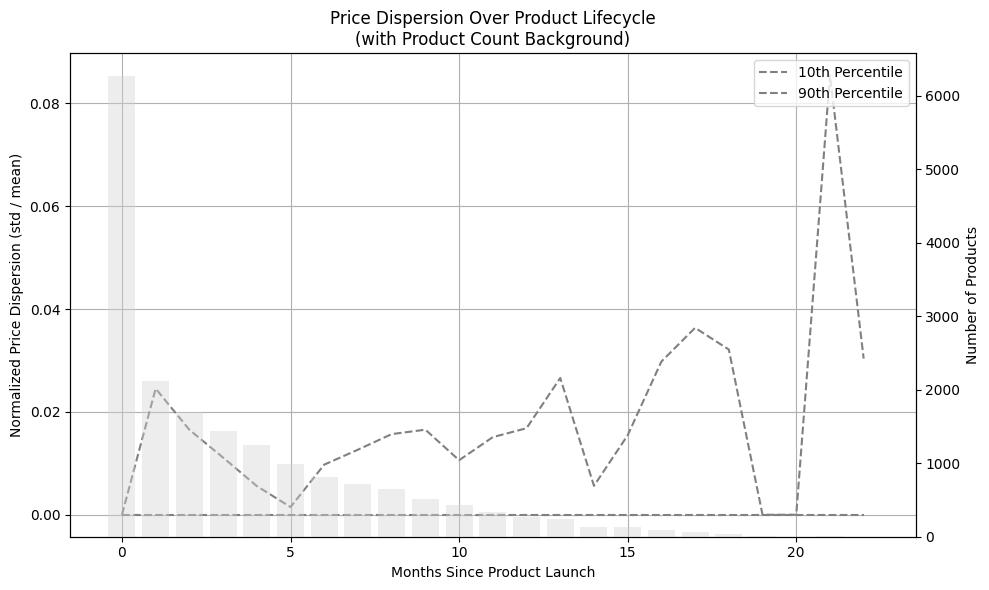

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Prepare data ---
# Ensure date format
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# Merge prices and timestamps
merged = order_items.merge(orders[['order_id', 'month']], on='order_id')

# --- Step 2: Get months since product first appeared ---
# First month of each product
first_months = merged.groupby('product_id')['month'].min().reset_index()
first_months.columns = ['product_id', 'first_month']

# Merge and compute product age
merged = merged.merge(first_months, on='product_id')
merged['months_on_market'] = (merged['month'] - merged['first_month']).apply(lambda x: x.n)

# --- Step 3: Compute normalized price dispersion per product-month ---
grouped = merged.groupby(['product_id', 'months_on_market'])['price'].agg(['mean', 'std']).reset_index()
grouped['normalized_dispersion'] = grouped['std'] / grouped['mean']
grouped = grouped.dropna(subset=['normalized_dispersion'])  # Remove invalid rows

# --- Step 4: Aggregate across products for each month-on-market (with 10th and 90th percentiles) ---
summary = grouped.groupby('months_on_market')['normalized_dispersion'].agg(
    mean='mean',
    p10=lambda x: np.percentile(x, 10),
    p90=lambda x: np.percentile(x, 90)
).reset_index()

# --- Count number of products contributing at each age ---
activity = grouped.groupby('months_on_market')['product_id'].nunique().reset_index()
activity.columns = ['months_on_market', 'n_products']

# --- Plot with secondary axis for product count ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot on secondary axis (product count)
ax2 = ax1.twinx()
ax2.bar(
    activity['months_on_market'],
    activity['n_products'],
    color='lightgray',
    alpha=0.4,
    label='Number of Products',
    width=0.8
)

# Line plots on main axis
ax1.plot(summary['months_on_market'], summary['p10'], linestyle='--', color='gray', label='10th Percentile')
ax1.plot(summary['months_on_market'], summary['p90'], linestyle='--', color='gray', label='90th Percentile')

# Axis labels and title
ax1.set_xlabel('Months Since Product Launch')
ax1.set_ylabel('Normalized Price Dispersion (std / mean)')
ax2.set_ylabel('Number of Products')

# Title and layout
plt.title('Price Dispersion Over Product Lifecycle\n(with Product Count Background)')
ax1.grid(True)
fig.tight_layout()

# Legend from main axis
ax1.legend(loc='upper right')
plt.show()



# Histogram of Number of Competitors 10/17

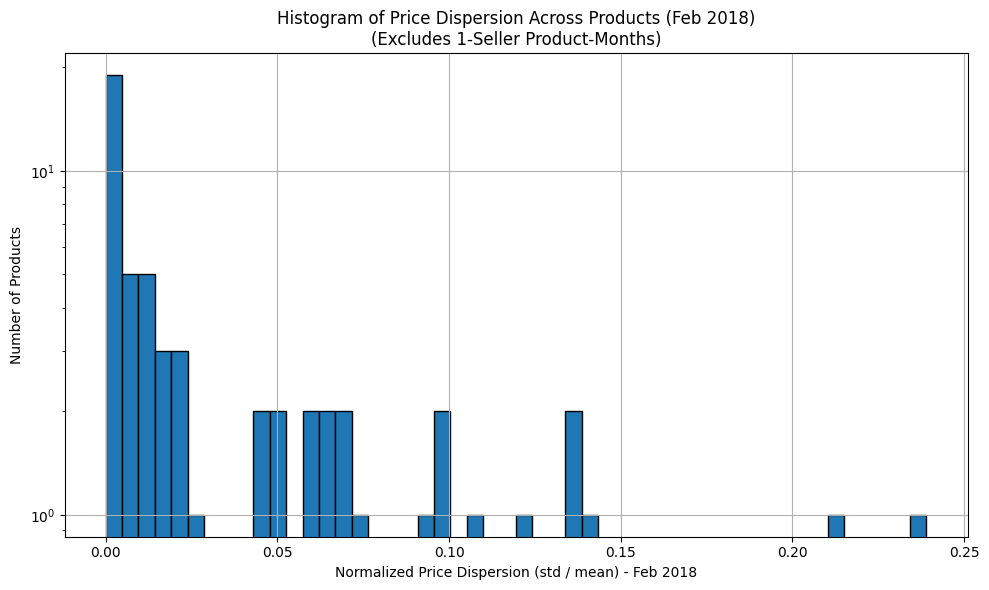

In [87]:
# Ensure timestamp is in datetime format
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Filter for February 2018
feb_orders = orders[orders['order_purchase_timestamp'].dt.to_period('M') == '2018-02']
feb_items = order_items.merge(feb_orders[['order_id', 'order_purchase_timestamp']], on='order_id')

# Exclude product-months with only 1 seller
seller_counts = feb_items.groupby('product_id')['seller_id'].nunique().reset_index(name='num_sellers')
valid_products = seller_counts[seller_counts['num_sellers'] > 1]['product_id']
feb_items = feb_items[feb_items['product_id'].isin(valid_products)]

# Calculate normalized price dispersion
feb_items['price_disp'] = feb_items.groupby('product_id')['price'].transform(lambda x: x.std() / x.mean())
price_disp_feb = feb_items[['product_id', 'price_disp']].drop_duplicates()
price_disp_feb = price_disp_feb[~price_disp_feb['price_disp'].isna()]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(price_disp_feb['price_disp'], bins=50, edgecolor='k')
plt.xlabel('Normalized Price Dispersion (std / mean) - Feb 2018')
plt.ylabel('Number of Products')
plt.title('Histogram of Price Dispersion Across Products (Feb 2018)\n(Excludes 1-Seller Product-Months)')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()



In [88]:
# Count unique products overall
total_products = feb_items['product_id'].nunique()

# Filter only products with >1 seller
seller_counts['num_sellers'] = pd.to_numeric(seller_counts['num_sellers'], errors='coerce')
multi_seller_products = seller_counts[seller_counts['num_sellers'] > 1].shape[0]

print(f"Total products in Feb 2018: {total_products}")
print(f"Products with >1 seller: {multi_seller_products}")


Total products in Feb 2018: 57
Products with >1 seller: 57


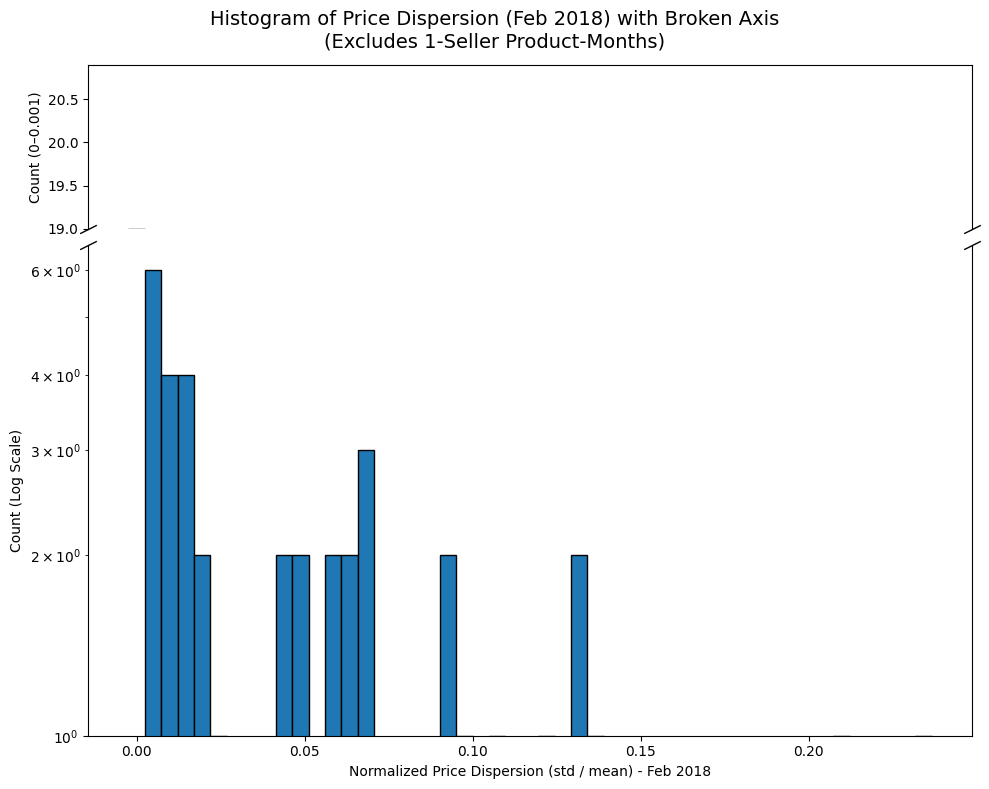

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# --- Histogram binning ---
bin_edges = np.linspace(0, price_disp_feb['price_disp'].max(), 50)
counts, bins = np.histogram(price_disp_feb['price_disp'], bins=bin_edges)

# --- Identify bin ranges ---
cutoff = 0.001
first_bin_mask = (bins[:-1] < cutoff)
main_bin_mask = ~first_bin_mask

# --- Plot with broken y-axis ---
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 3]})

# First bin (0–0.001)
ax1.bar(bins[:-1][first_bin_mask], counts[first_bin_mask], width=np.diff(bins)[first_bin_mask], edgecolor='k')
ax1.set_ylim(counts[first_bin_mask].min(), counts[first_bin_mask].max() * 1.1)

# Remaining bins (log-scaled)
ax2.bar(bins[:-1][main_bin_mask], counts[main_bin_mask], width=np.diff(bins)[main_bin_mask], edgecolor='k')
ax2.set_ylim(1, counts[main_bin_mask].max() * 1.1)
ax2.set_yscale('log')

# Broken axis aesthetics
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False, bottom=False)
ax2.tick_params(top=False)

d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# Labels and title
ax2.set_xlabel('Normalized Price Dispersion (std / mean) - Feb 2018')
ax1.set_ylabel('Count (0–0.001)')
ax2.set_ylabel('Count (Log Scale)')
fig.suptitle('Histogram of Price Dispersion (Feb 2018) with Broken Axis\n(Excludes 1-Seller Product-Months)', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.show()
